In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime

file_in = 'wifi_test_rpi.csv'
file_in = 'wifi_test.csv'

''' read in data and format test time '''
df = pd.read_csv(file_in, index_col=0)
df = df.reset_index()
df['test_time']=df['index'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d_%H:%M:%S'))

''' encode deivce ssid '''
ssid_dict = {}
for c,i in enumerate(df.device_ssid.unique()):
    ssid_dict[i] = c+1

df['ssid_id'] = df.device_ssid.apply(lambda x: ssid_dict[x])


In [11]:
df.shape

(546, 7)

In [12]:
df.tail()

,index,down,up,device_ssid,device_ip,test_time,ssid_id
541,2021117_8:16:5,89.05,74.82,Password's On The Fridge-5G,192.168.1.14,2021-11-07 08:16:05,1
542,2021117_8:16:25,89.45,70.19,Password's On The Fridge-5G,192.168.1.14,2021-11-07 08:16:25,1
543,2021117_8:16:45,87.84,73.48,Password's On The Fridge-5G,192.168.1.14,2021-11-07 08:16:45,1
544,2021117_8:17:6,91.36,73.16,Password's On The Fridge-5G,192.168.1.14,2021-11-07 08:17:06,1
545,2021117_8:17:26,103.58,95.06,Password's On The Fridge-5G,192.168.1.14,2021-11-07 08:17:26,1


## set datetime range

In [20]:
dt_start = datetime.datetime.strptime('20211020_7:00:00', "%Y%m%d_%H:%M:%S")
dt_end = datetime.datetime.strptime('20211231_23:00:00', "%Y%m%d_%H:%M:%S")

df = df[(df.test_time>dt_start)&(df.test_time<dt_end)]

print(df.shape)
print("Last Test Recorded: %s"%(df.iloc[-1]['test_time']))

(545, 8)
Last Test Recorded: 2021-11-07 08:17:26


### drop na

In [21]:
df = df.dropna()
df.shape

(545, 8)

## plot all data

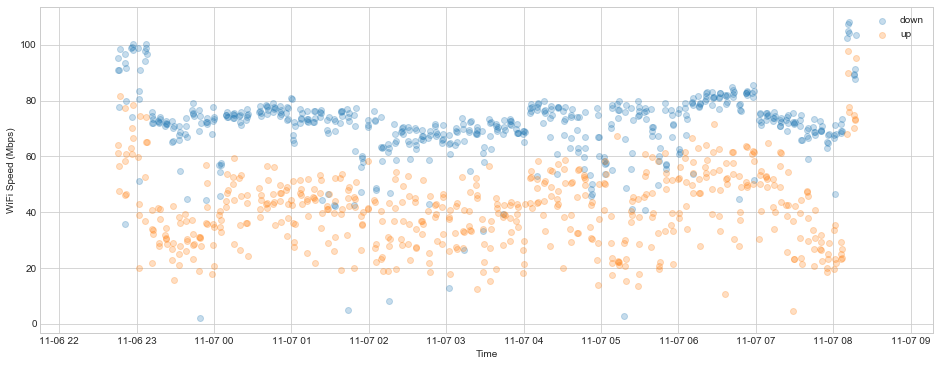

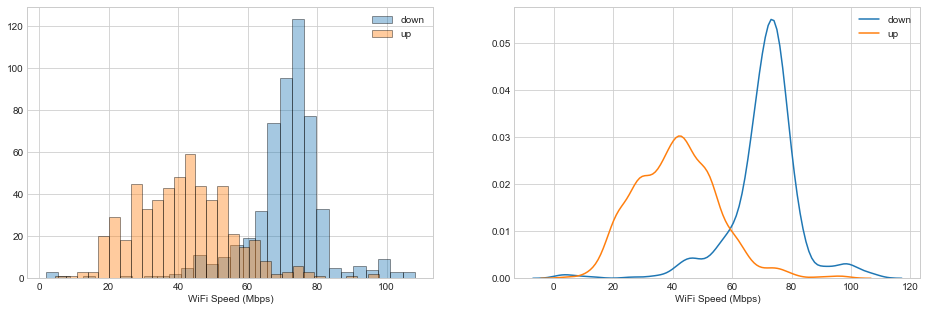

In [22]:
plt.style.use('seaborn-whitegrid')

edgecolors = ['red','green','yellow','black','purple']
fillcolors = {'up':'blue',
              'down':'orange'}
df['color'] = df.ssid_id.apply(lambda x: edgecolors[x-1])
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
for i in df[['down','up']]:
    ax.scatter(x=df.test_time.values, y=df[i],
               alpha=0.25, 
               #facecolors=fillcolors[i],
               #color=fillcolors[i],
               #edgecolor=df.color,
               #plotnonfinite=True,
               label=i)

ax.set_xlim(df.test_time.min() - datetime.timedelta(hours=1),
            df.test_time.max() + datetime.timedelta(hours=1))
ax.set_xlabel('Time')
ax.set_ylabel('WiFi Speed (Mbps)')
ax.legend()

fig = plt.figure(figsize=(16,5))
ax2 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
for i in df[['down','up']]:
    ax2.hist(df[i].fillna(0), bins=30, edgecolor='black', alpha=0.4,density=False)
    sns.kdeplot(df[i].fillna(0), bw=3)
    
ax2.set_xlabel('WiFi Speed (Mbps)')
ax2.legend()
ax3.set_xlabel('WiFi Speed (Mbps)');

## plot all by SSID

 Password's On The Fridge
 Password's On The Fridge-5G


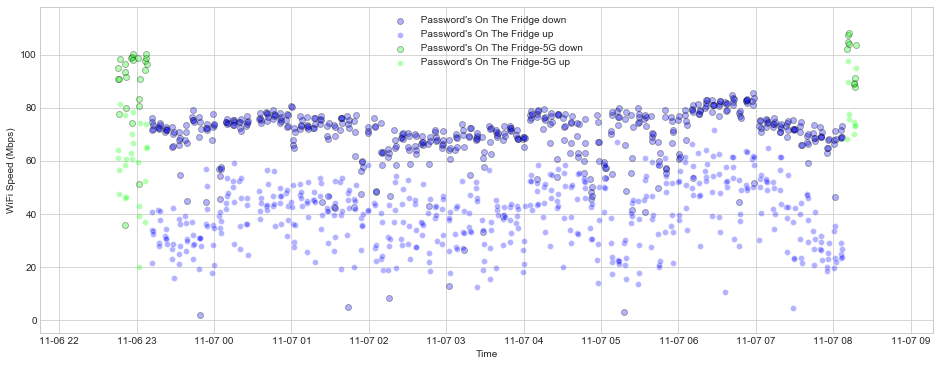

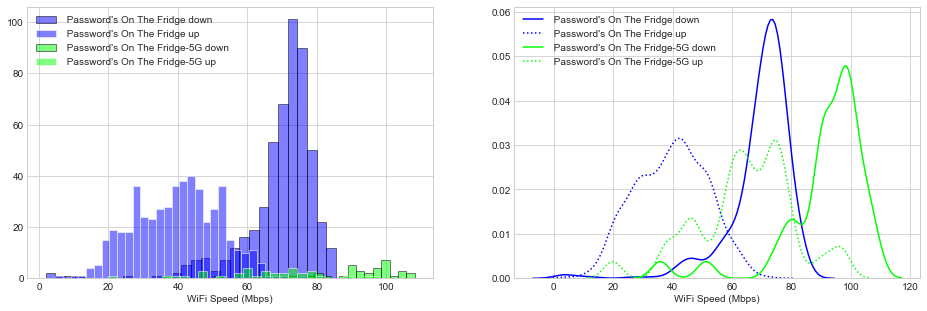

In [23]:
plt.style.use('seaborn-whitegrid')

edgecolors = ['black','white']#,'black','black','purple']
linestyles=['-',':']
fillcolors = {'down':'blue',
              'up':'orange'}

colors = cm.brg(np.linspace(0, 1, df.device_ssid.nunique()))
#df['color'] = df.ssid_id.apply(lambda x: edgecolors[x-1])
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)

for c,ssid in enumerate(df.groupby('device_ssid')):
    print(ssid[0])
    df_ = ssid[1]
    for d,i in enumerate(df_[['down','up']]):
        ax.scatter(x=df_.test_time.values, y=df_[i],
                   alpha=0.3, 
                   label="%s %s" %(ssid[0],i),
                   color=colors[c],
                   edgecolors=edgecolors[d]
                  )

ax.set_xlim(df.test_time.min() - datetime.timedelta(hours=1),
            df.test_time.max() + datetime.timedelta(hours=1))
ax.set_ylim(-5, 118)
ax.set_xlabel('Time')
ax.set_ylabel('WiFi Speed (Mbps)')
ax.legend()



fig = plt.figure(figsize=(16,5))
ax2 = fig.add_subplot(121)
ax3 = fig.add_subplot(122)
for c,ssid in enumerate(df.groupby('device_ssid')):
    df_ = ssid[1]
    for d,i in enumerate(df_[['down','up']]):
        ax2.hist(df_[i],
                 bins=30,
                 color=colors[c],
                 edgecolor=edgecolors[d],
                   alpha=0.5,
                label="%s %s" %(ssid[0],i))
        
    for e,i in enumerate(df_[['down','up']]):
        sns.kdeplot(df_[i].fillna(0), bw=3,
                    color=colors[c],
                    linestyle=linestyles[e],
                   label="%s %s" %(ssid[0],i))
    
ax2.set_xlabel('WiFi Speed (Mbps)')
ax2.legend()
ax3.set_xlabel('WiFi Speed (Mbps)');

## plot the last N hours, broken out by SSID (if more than 1 exist)

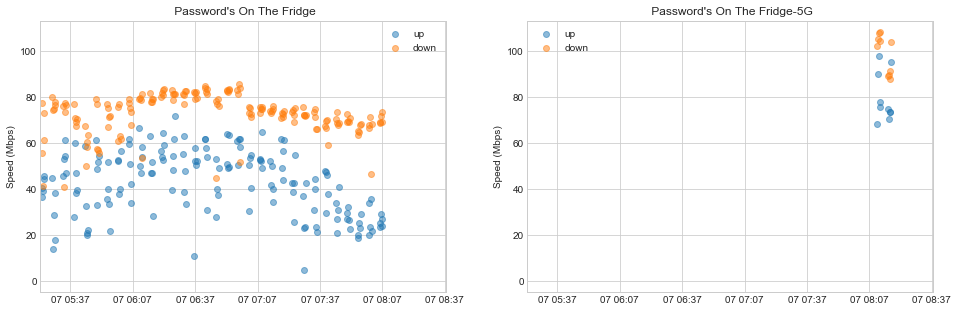

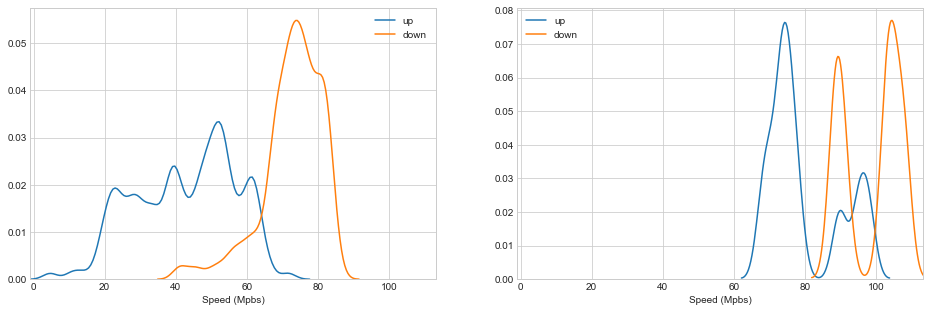

In [24]:
fig1 = plt.figure(figsize=(16,5))
fig2 = plt.figure(figsize=(16,5))

window = 3  # hours
df_ = df[df.test_time>=datetime.datetime.now() - datetime.timedelta(hours=window)]
df_ = df_.dropna()

for c,ssid in enumerate(df_.device_ssid.unique()):
    #plot_num = df_.device_ssid.nunique() - c
    plot_num = c+1
    #print(ssid, plot_num)
    ssid_df = df_[df_.device_ssid==ssid]
    ax1 = fig1.add_subplot(1, df_.device_ssid.nunique(), plot_num)
    ax2 = fig2.add_subplot(1, df_.device_ssid.nunique(), plot_num)
    plot_num+=1

    for i in ssid_df[['up','down']]:
        ''' scatter plot '''
        x,y = ssid_df.test_time, ssid_df[i]
        ax1.scatter(x.values, y,
                  alpha=0.5)
        #ax1.set_xticks(x_range)
        ax1.set_xlim(datetime.datetime.now() - datetime.timedelta(hours=window),
                    datetime.datetime.now()+datetime.timedelta(hours=.25))
        ax1.set_ylim(-5, df.down.max()+5)
        ax1.title.set_text(ssid)
        ax1.legend()
        ''' kde plots '''
        sns.kdeplot(ssid_df[i], bw=2)
        ax2.set_xlabel('Speed (Mpbs)')
        ax2.set_xlim(-1, df.down.max()+5)
    ax1.set_ylabel('Speed (Mbps)')
    
        #sns.kdeplot(data=ssid_df[i])
    


## Plot all data broken out by SSID

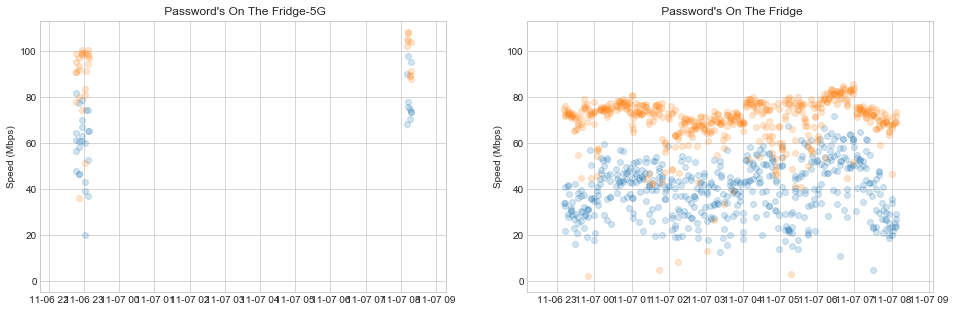

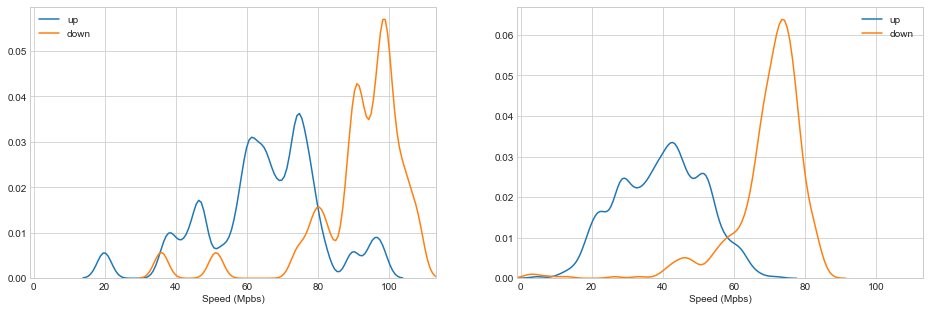

In [25]:
fig1 = plt.figure(figsize=(16,5))
fig2 = plt.figure(figsize=(16,5))

df_ = df.dropna()
x_range = pd.date_range(df.test_time.min() - datetime.timedelta(hours=1),
                        df.test_time.max() + datetime.timedelta(hours=1),
                        freq='1H')

for c,ssid in enumerate(df_.device_ssid.unique()):
    #plot_num = df_.device_ssid.nunique() - c
    plot_num = c+1
    #print(ssid, plot_num)
    ssid_df = df[df.device_ssid==ssid]
    ax1 = fig1.add_subplot(1, df_.device_ssid.nunique(), plot_num)
    ax2 = fig2.add_subplot(1, df_.device_ssid.nunique(), plot_num)
    plot_num+=1

    for i in ssid_df[['up','down']]:
        ''' scatter plot '''
        x,y = ssid_df.test_time, ssid_df[i]
        ax1.scatter(x.values, y,
                  alpha=0.2)
        #ax1.set_xticks(x_range)
        ax1.set_xlim(ssid_df.test_time.min() - datetime.timedelta(hours=1),
            ssid_df.test_time.max() + datetime.timedelta(hours=1))
        ax1.set_ylim(-5, df.down.max()+5)
        ax1.title.set_text(ssid)
        ''' kde plots '''
        sns.kdeplot(ssid_df[i], bw=2)
        ax2.set_xlabel('Speed (Mpbs)')
        ax2.set_xlim(-1, df.down.max()+5)
    ax1.set_ylabel('Speed (Mbps)')
    
        #sns.kdeplot(data=ssid_df[i])
    
